# 

# Combination of Two Machine Learning Models

1. [Libraries and Data Loading](#1)
2. [Statistics](#2)
3. [Feature Selection](#3)
4. [Feature Extration](#4)
5. [Processing Unsupervised model](#5)
6. [Processing Supervised model](#6)
7. [K-means Clustering and Artificail Neural Network](#7)
8. [Plots](#8)


## <a id="1">1. Libraries and Data Loading</a>
Pandas is managed to read the xlsx file and create two dataframes: one for traning and another for testing.<br>
All sheets from traning data are merged into one dataframe and then transformed to a spark dataframe.<br>
Similar, all sheets from test data are merged into one dataframe and then transformed to a spark dataframe.

In [81]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
import pyspark.pandas as spd
import pandas as pandi
import matplotlib.pyplot as plt
import seaborn as seab
import plotly.express as ploti
import numpy as numpi
import warnings


In [82]:

warnings.filterwarnings('ignore')

# Creating a spark session
spark = SparkSession.builder.appName('DoA').getOrCreate()

# Loading XLSX file into Pandas to create one dataframe concatenating the sheets from Train-1 to Train-10
df_pd = pandi.read_excel('./data/Project data set 1 (for reports 1 and 3) .xlsx', sheet_name=['Train-1', 'Train-2', 'Train-3', 'Train-4', 'Train-5', 'Train-6', 'Train-7', 'Train-8', 'Train-9', 'Train-10'])
df_pd = pandi.concat(df_pd.values(), ignore_index=True)

# Creating spark dataframe of training data
df_training = spark.createDataFrame(df_pd)

# Loading XLSX file into Pandas with the sheets from Test-1 to Test-5
df_pd = pandi.read_excel('./data/Project data set 1 (for reports 1 and 3) .xlsx', sheet_name=['Test-1', 'Test-2', 'Test-3', 'Test-4', 'Test-5'])
df_pd = pandi.concat(df_pd.values(), ignore_index=True)

# Creating spark dataframe of testing data
df_testing = spark.createDataFrame(df_pd)

# Printing Columns
print('\nColumn names:\n')
spark.createDataFrame(df_training.columns, 'string').show(len(df_training.columns), truncate=False)
print(f'Training dataset shape: {df_training.toPandas().shape}')
print(f'Testing dataset shape: {df_testing.toPandas().shape}')



Column names:

+-----+
|value|
+-----+
|BIS  |
|x1   |
|x2   |
|x3   |
|x4   |
|x5   |
|x6   |
|x7   |
|x8   |
+-----+

Training dataset shape: (27452, 9)
Testing dataset shape: (15185, 9)


## <a id="2">2. Statistics</a>

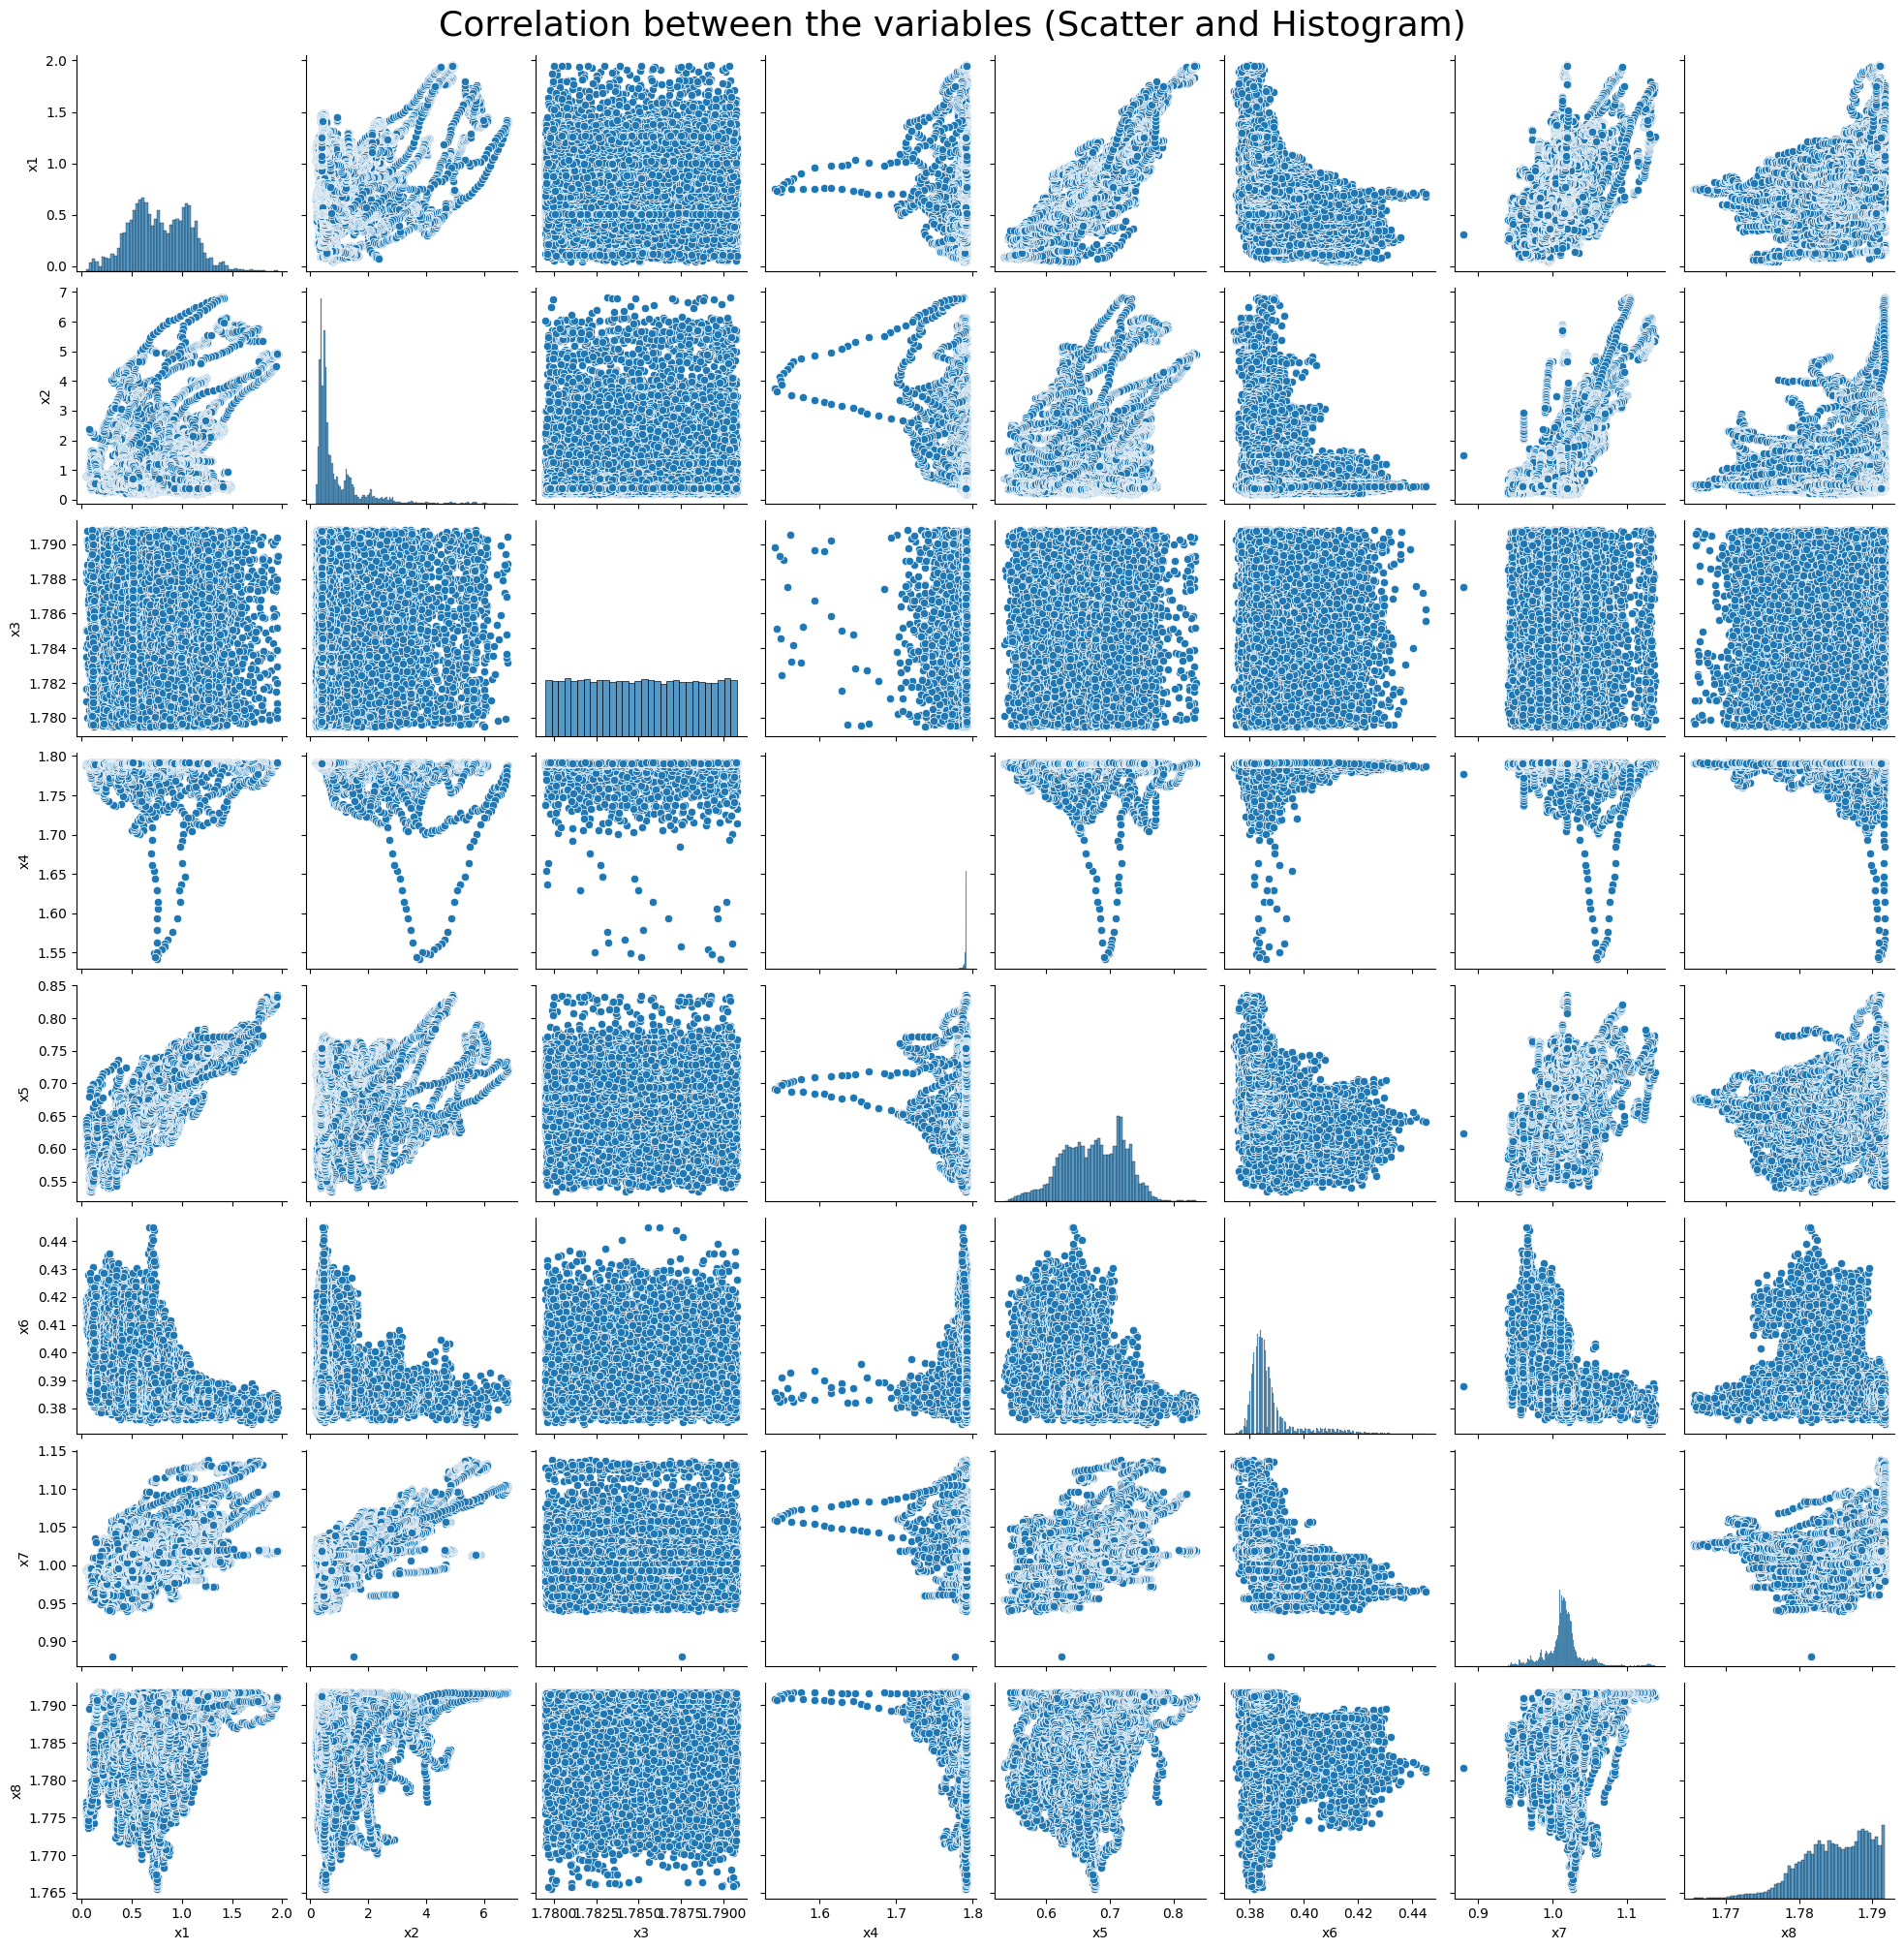

       x1     x2     x3     x4     x5     x6     x7     x8
x1  1.000  0.255  0.005  0.035  0.902 -0.475  0.469  0.342
x2  0.255  1.000  0.011 -0.330  0.190 -0.174  0.608  0.284
x3  0.005  0.011  1.000 -0.006  0.007  0.002  0.009  0.011
x4  0.035 -0.330 -0.006  1.000  0.038  0.005 -0.130 -0.095
x5  0.902  0.190  0.007  0.038  1.000 -0.469  0.420  0.340
x6 -0.475 -0.174  0.002  0.005 -0.469  1.000 -0.539 -0.116
x7  0.469  0.608  0.009 -0.130  0.420 -0.539  1.000  0.173
x8  0.342  0.284  0.011 -0.095  0.340 -0.116  0.173  1.000


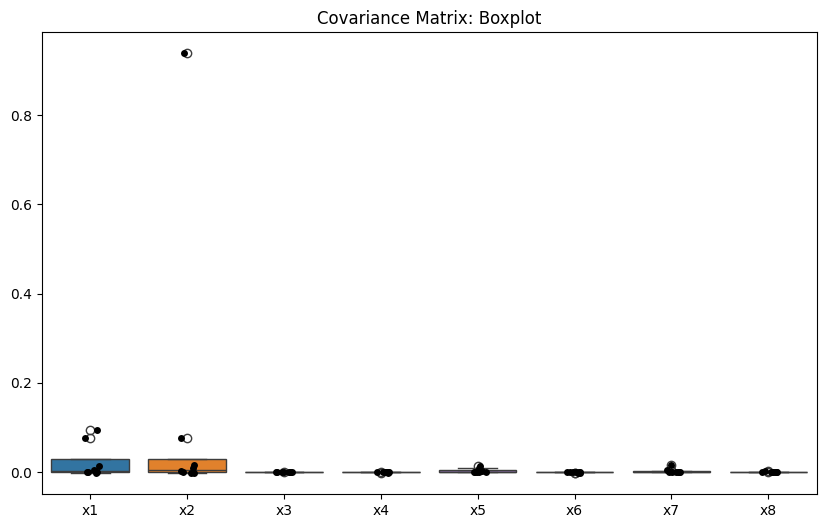

In [92]:
# Visual correlation between variables using parplot from seaborn
seab.pairplot(df_training.drop('BIS').toPandas())
plt.suptitle('Correlation between the variables (Scatter and Histogram)', fontsize=26, y=1.01)
plt.show()


# Generating basic statistics
df_training.drop('BIS').toPandas().describe().round(3)

# Generating the Correlation Matrix (Pearson Coefficient)
personCorrM = df_training.drop('BIS').toPandas().corr(method='pearson').round(3)
print(personCorrM)

heatmap_mask = numpi.triu(numpi.ones_like(df_training.drop('BIS').toPandas().corr(method='pearson'), dtype=bool))
heatmap_mask_cm = personCorrM.mask(heatmap_mask)

ploti_fig = ploti.imshow(heatmap_mask_cm,
                        color_continuous_scale='rdylgn',
                        text_auto=True,
                        width=700, height=700,
                        zmin=-1, zmax=1,
                        title='Correlation Matrix')
ploti_fig.show()

# Covariance Matrix in boxplot
boxplot_cv = df_training.drop('BIS').toPandas().cov()

fig = plt.figure(figsize=(10,6))
plt.title('Covariance Matrix: Boxplot')

seab.stripplot(data=boxplot_cv, color='black')
seab.boxplot(data=boxplot_cv)
plt.show()



